# 군집분석

한 기업이 해킹을 당해서 우리에게 도움을 요청했습니다! 다행스럽게도 그 기업의 포렌식 기술자들은 session time, location, wpm typing speed 등과 같은 해킹에 대한 귀중한 정보를 수집했습니다. 담당 포렌식 기술자와의 회의에서 듣기로는 해커들이 서버에 접속하는데에 사용한 각 세션의 메타 데이터들을 수집한 것이라고 합니다.

다음은 수집된 데이터입니다

- Session_Connection_Time : 세션이 지속된 시간(분)입니다. (있었던 시간)
- Bytes Transferred : 세션 중에 전송된 데이터 용량(MB)입니다.
- Kali_Trace_Used : 해커의 Kali Linux 사용 여부입니다. (해킹운영체제사용여부)
- Servers_Corrupted : 공격으로 손상된 서버 수 입니다.
- Pages_Corrupted : 무단으로 접근한 페이지 수 입니다.
- Location : 공격이 시작된 위치입니다.(해커들이 VPN을 사용했기 때문에 아마 쓸모가 없을 것 같습니다. vpn 돌려서 왔다리갔다리...)
- WPM_Typing_Speed : 세션 로그를 기준으로 예상한 타이핑 속도입니다. (명령 코드)

이 회사에서는 3명의 해커를 의심 중입니다. 2명의 해커는 어느정도 확신하고 있지만 세 번째 해커가 해킹에 연루되었는지 아직 확실하지 않습니다. 우리에게 의뢰한 부분은 이 부분입니다. 즉, 이번 해킹 사건에서 2명이 공격을 한 것인지 3명이 공격을 한 것인지 분석해달라고 합니다. 확실하지는 않지만 클러스터링으로 알아 볼 수 있을 것 같습니다.

마지막으로 한가지 알려드릴 중요한 사실은, 각 해커들의 공격횟수는 거의 동일합니다. 예를 들어, 총 공격 횟수가 100번 이었다면, 50건씩 2명이 공격을 했거나 3명이 약 33건씩 공격을 했다는 말입니다. 데이터는 hack_data.csv 파일로 전달해 드리겠습니다.

- 그 딱 한사람의 증거를 잡고싶은거임

In [64]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 차이 검정할것임
from scipy import stats
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score # 실루엣 계수 계산

# 데이터 까보기

In [101]:
df = pd.read_csv("./data/hack_data.csv")

In [102]:
df.head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80
4,20.0,408.50,0,3.57,8.0,Iraq,71.28


In [103]:
df.shape

(334, 7)

In [104]:
df.dtypes

Session_Connection_Time    float64
Bytes Transferred          float64
Kali_Trace_Used              int64
Servers_Corrupted          float64
Pages_Corrupted            float64
Location                    object
WPM_Typing_Speed           float64
dtype: object

In [6]:
df.isna().sum()

Session_Connection_Time    0
Bytes Transferred          0
Kali_Trace_Used            0
Servers_Corrupted          0
Pages_Corrupted            0
Location                   0
WPM_Typing_Speed           0
dtype: int64

In [7]:
df.describe()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,30.008982,607.245269,0.511976,5.258503,10.838323,57.342395
std,14.088201,286.335932,0.500607,2.301907,3.063526,13.411063
min,1.000000,10.000000,0.000000,1.000000,6.000000,40.000000
25%,18.000000,372.200000,0.000000,3.122500,8.000000,44.127500
50%,31.000000,601.650000,1.000000,5.285000,10.500000,57.840000
75%,42.000000,843.702500,1.000000,7.400000,14.000000,70.577500
max,60.000000,1330.500000,1.000000,10.000000,15.000000,75.000000


- 단위가 다 달라서 스케일링 해줘야 군집분석 하기 용이함

# 진짜 Location 필요없나?

In [75]:
df["Location"].value_counts()

Location
United States Virgin Islands                    6
Mauritania                                      5
Czech Republic                                  5
Guinea-Bissau                                   5
Palestinian Territory                           4
                                               ..
Antarctica (the territory South of 60 deg S)    1
Myanmar                                         1
Belgium                                         1
Germany                                         1
Canada                                          1
Name: count, Length: 181, dtype: int64

### 최대 빈도 location 데이터 까보기

In [8]:
df[df["Location"] == "United States Virgin Islands"]

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
53,13.0,416.90,1,2.76,8.0,United States Virgin Islands,71.63
105,20.0,271.97,1,3.38,8.0,United States Virgin Islands,73.17
129,15.0,447.83,0,2.60,8.0,United States Virgin Islands,71.24
173,47.0,592.93,1,6.65,13.0,United States Virgin Islands,47.15
304,52.0,800.64,0,6.10,14.0,United States Virgin Islands,43.45
327,50.0,842.78,0,6.62,15.0,United States Virgin Islands,44.69


- United States Virgin Islands 라는 곳에서 가장 많이 접속 (의미있는지는 모르겠음)

# 독립변수의 상관관계 알아보기

In [105]:
clean_df = df.drop(["Location"], axis = 1)
clean_df.corr()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
Session_Connection_Time,1.000000,0.713861,0.034687,0.808394,0.844167,-0.866077
Bytes Transferred,0.713861,1.000000,0.072436,0.739822,0.784081,-0.793344
Kali_Trace_Used,0.034687,0.072436,1.000000,0.033242,0.016931,-0.026560
Servers_Corrupted,0.808394,0.739822,0.033242,1.000000,0.897210,-0.915629
Pages_Corrupted,0.844167,0.784081,0.016931,0.897210,1.000000,-0.968662
WPM_Typing_Speed,-0.866077,-0.793344,-0.026560,-0.915629,-0.968662,1.000000


- Session_Connection_Time 와 Servers_Corrupted 상관관계 있음
- Session_Connection_Time 와 Pages_Corrupted 상관관계 있음
- Session_Connection_Time 와 WPM_Typing_Speed 상관관계 있음(큰 음의 상관관계)
- Session_Connection_Time 와 Bytes Transferred 상관관계 있음
  
- **여기서 Session_Connection_Time 과 모든 상관관계가 유의미 한지 체크해야함**

### Session_Connection_Time 와 WPM_Typing_Speed 산점도

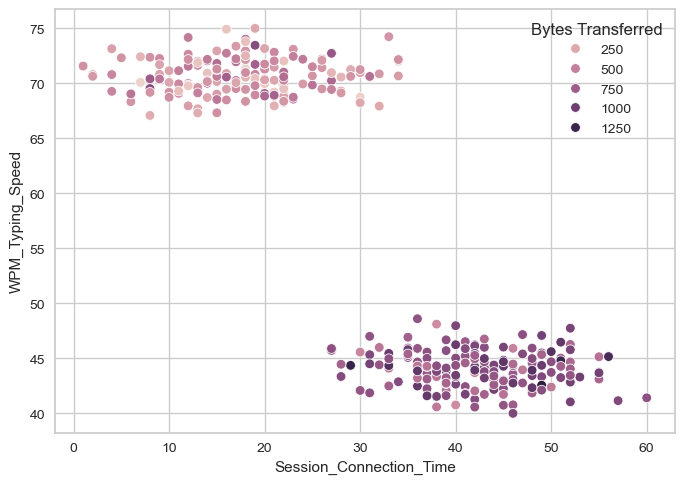

In [39]:
sns.scatterplot(data=clean_df, x="Session_Connection_Time", y="WPM_Typing_Speed", hue="Bytes Transferred")
plt.show()

- 시각화 해보니 session_connection_time 높으면 높을수록 typing speed 빠르고 Bytes Transferred 도 많구나~~

In [17]:
# 피어슨 상관계수 계산
correlation, p_value = stats.pearsonr(df["Session_Connection_Time"],df["WPM_Typing_Speed"])
print(f'피어슨 상관계수: {correlation}, p-value: {p_value}')

피어슨 상관계수: -0.8660771878695297, p-value: 5.435336694673726e-102


- 큰 음의 상관관계 유의미함
- 세션 연결이 길면 길수록 타이핑 속도가 빨라짐 자동 입력같은거 해킹 시도를 하는구나~

- 그럼 서버에 길게 접속하고 타이핑 속도가 이상하리만큼 빠르며 뭔 데이터를 많이 주면 줄수록 공격횟수가 많나???

In [22]:
# Pages_Corrupted 이랑 Servers_Corrupted 이랑 합쳐서 판단해봐도 좋을듯 싶어서 새로운 파생변수 만들기

In [113]:
clean_df["Corrupted"] = clean_df["Servers_Corrupted"] + clean_df["Pages_Corrupted"]

In [114]:
clean_df.head()

,Session_Connection_Time,Bytes Transferred,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,cluster1,cluster2,Corrupted
0,8.0,391.09,2.96,7.0,72.37,0,0,9.96
1,20.0,720.99,3.04,9.0,69.08,0,3,12.04
2,31.0,356.32,3.71,8.0,70.58,0,2,11.71
3,2.0,228.08,2.48,8.0,70.80,0,0,10.48
4,20.0,408.50,3.57,8.0,71.28,0,3,11.57


In [25]:
clean_df.corr()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,Corrupted
Session_Connection_Time,1.000000,0.713861,0.034687,0.808394,0.844167,-0.866077,0.850512
Bytes Transferred,0.713861,1.000000,0.072436,0.739822,0.784081,-0.793344,0.785117
Kali_Trace_Used,0.034687,0.072436,1.000000,0.033242,0.016931,-0.026560,0.024555
Servers_Corrupted,0.808394,0.739822,0.033242,1.000000,0.897210,-0.915629,0.965946
Pages_Corrupted,0.844167,0.784081,0.016931,0.897210,1.000000,-0.968662,0.980919
WPM_Typing_Speed,-0.866077,-0.793344,-0.026560,-0.915629,-0.968662,1.000000,-0.970667
Corrupted,0.850512,0.785117,0.024555,0.965946,0.980919,-0.970667,1.000000


- Servers_Corrupted 이랑 Pages_Corrupted 를 자세 하게 보고싶다

In [26]:
server = clean_df["Servers_Corrupted"]
page = clean_df["Pages_Corrupted"]

# 피어슨 상관계수 계산
correlation, p_value = stats.pearsonr(server,page)
print(f'피어슨 상관계수: {correlation}, p-value: {p_value}')

피어슨 상관계수: 0.8972103214181619, p-value: 6.896410263164079e-120


<Axes: xlabel='Servers_Corrupted', ylabel='Pages_Corrupted'>

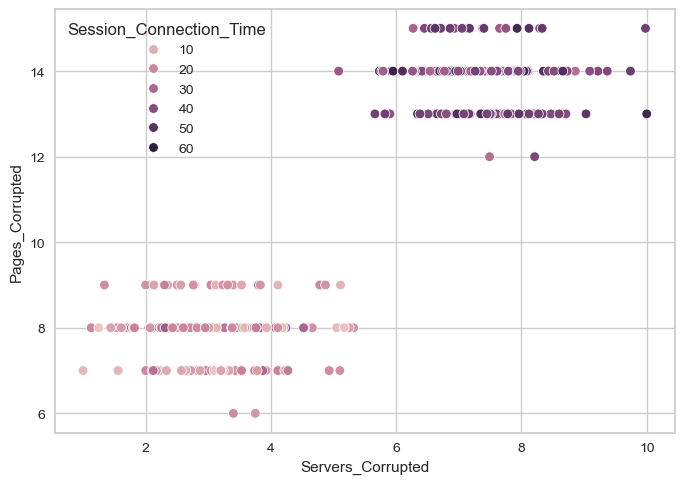

In [43]:
sns.scatterplot(data=clean_df, x="Servers_Corrupted", y="Pages_Corrupted", hue="Session_Connection_Time")

In [29]:
clean_df["Servers_Corrupted"].mean()

5.258502994011977

In [30]:
clean_df["Pages_Corrupted"].mean()

10.838323353293413

- 평균 2배차이인데
- page 공격을 더 많이 했네...

# pairplot 시각화

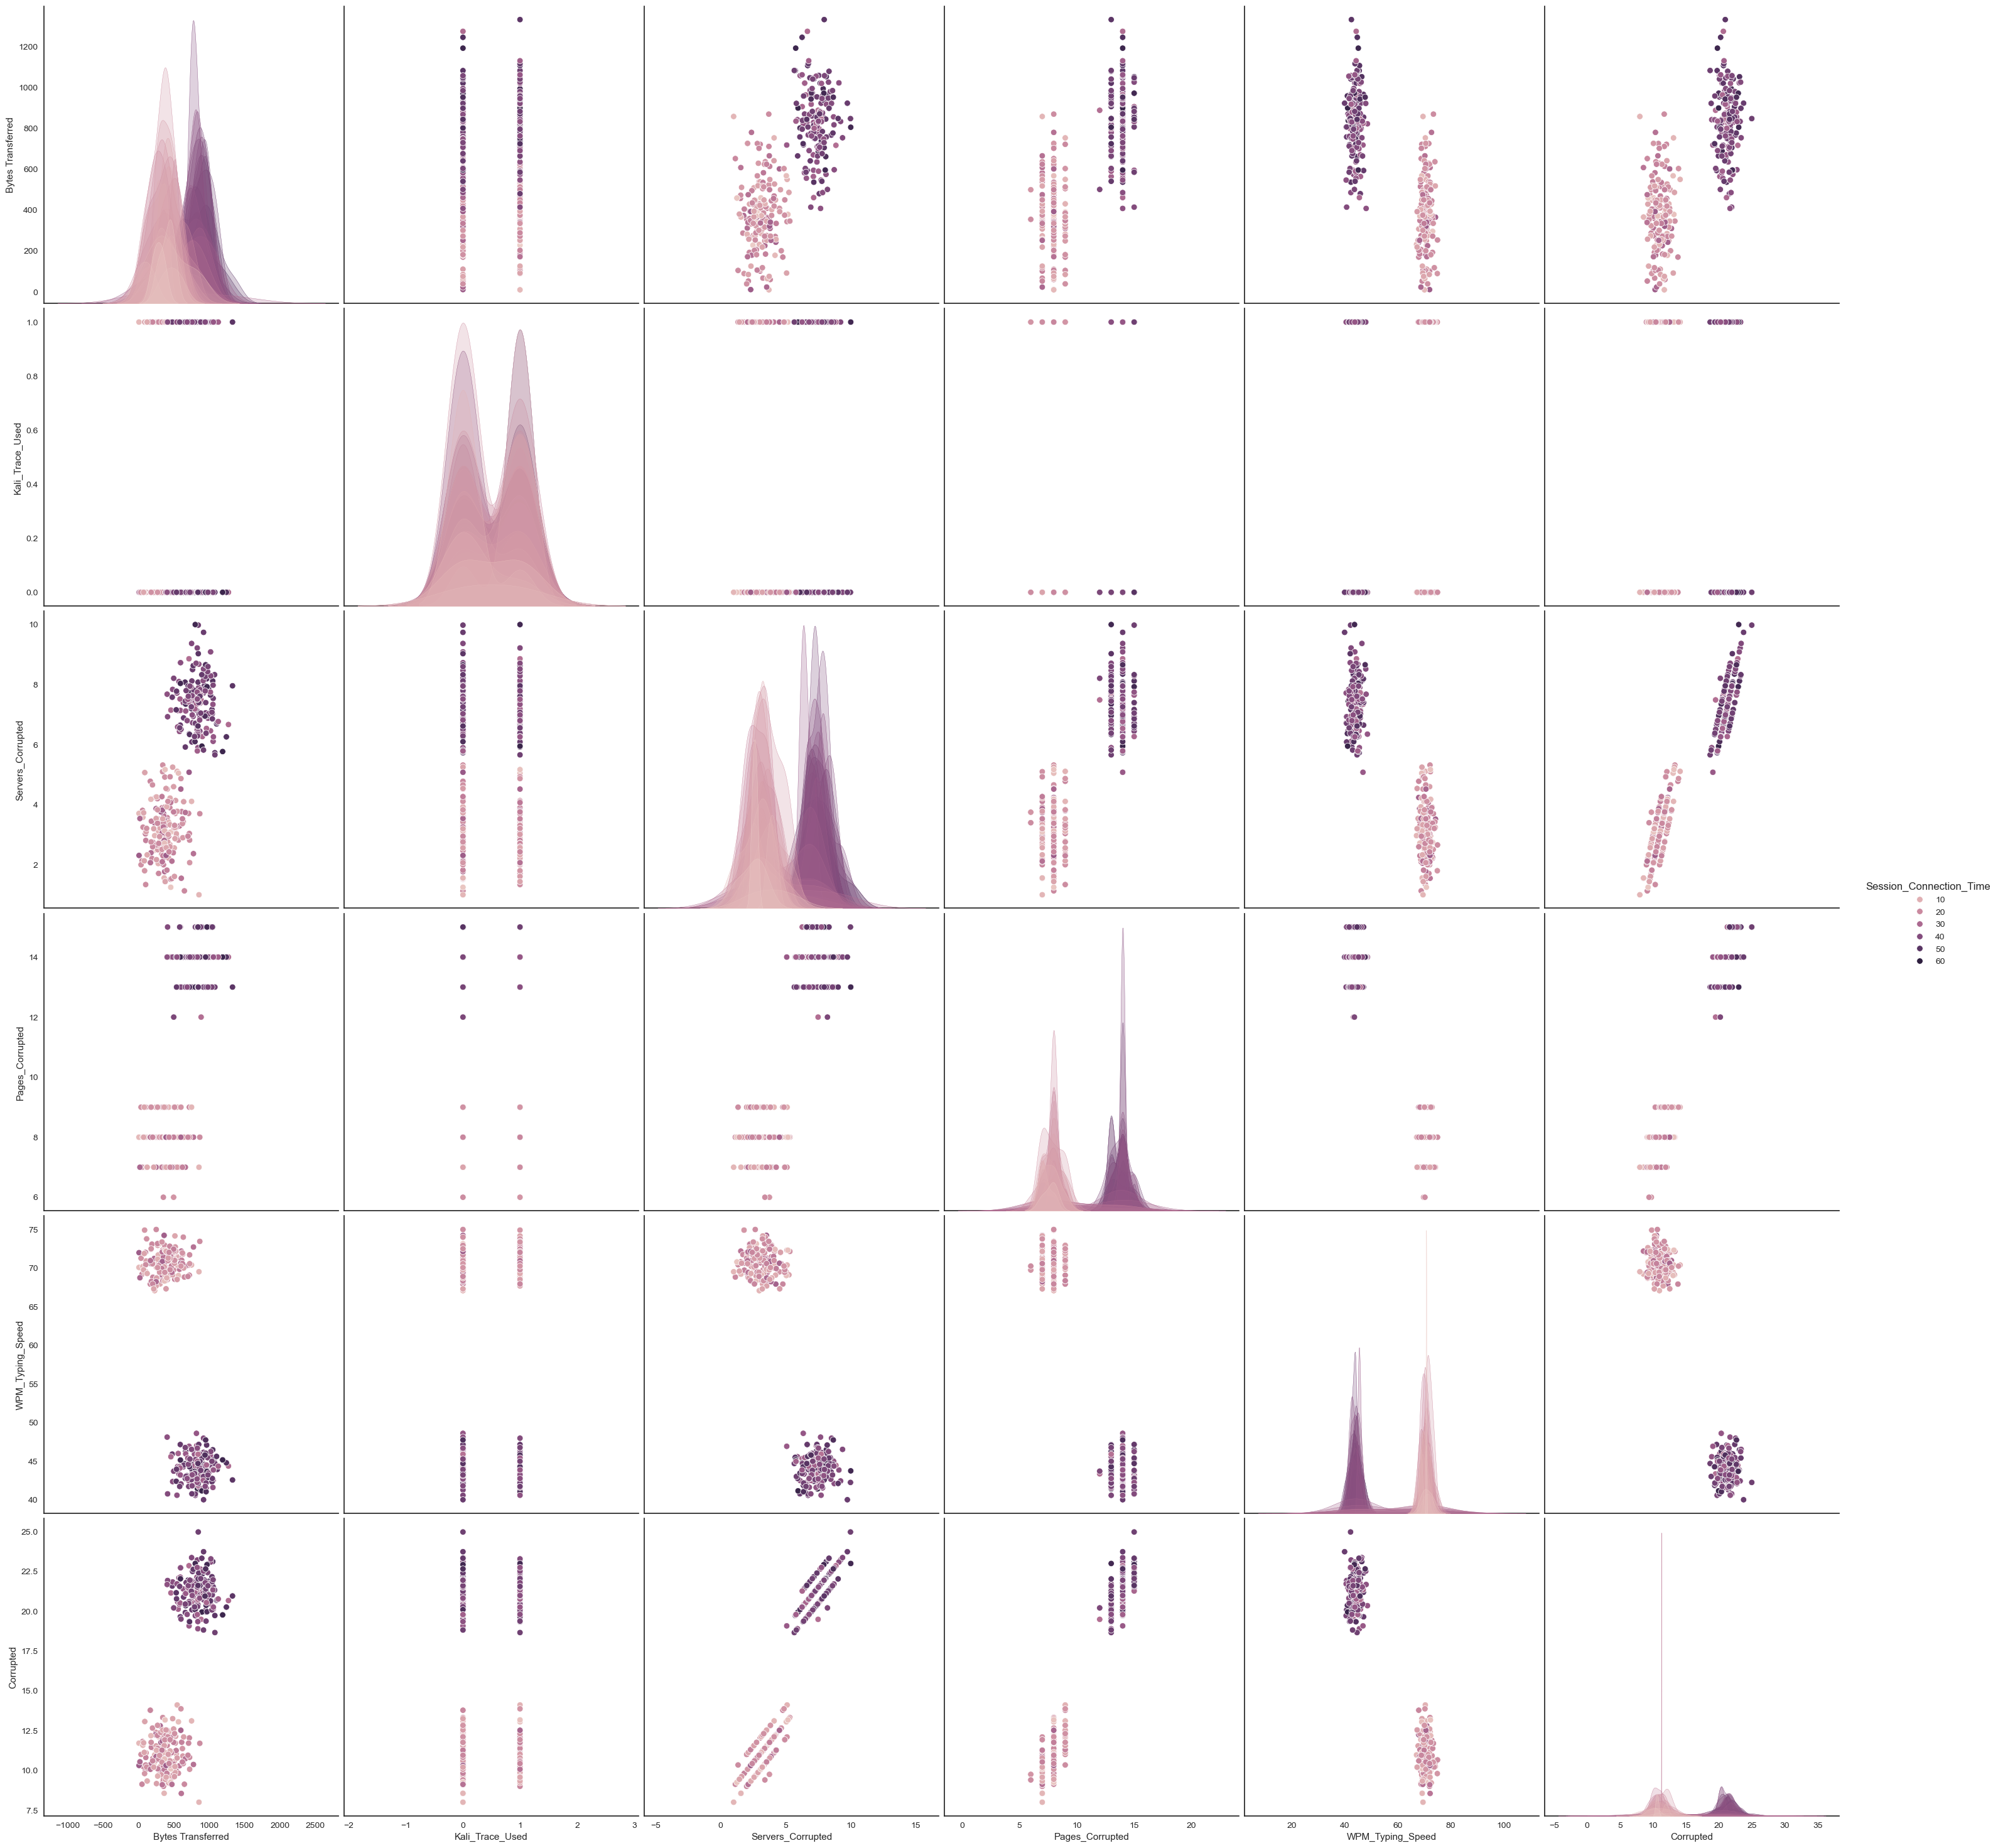

In [47]:
sns.set_style("ticks")
sns.pairplot(clean_df, hue = "Session_Connection_Time", height = 5)
plot_kws = {"s" : 100}
plt.show()

- 2명이라고 의심은 되는데 명확하게 판단이 안됨

In [48]:
# 상관관계가 깊은걸 찾는다고 해도 연류된 사람이 몇명인지는 모르잖아

## 군집하기전에 단위 스케일링

In [52]:
mm = MinMaxScaler()
scaled_df = mm.fit_transform(clean_df)

In [54]:
scaled_df.shape

(334, 7)

In [95]:
# 두명으로 쪼개보자
km  = KMeans(n_clusters = 2, random_state = 33)
km.fit(clean_df)

# 최저 SSE 값
print("" ,km.inertia_)

# 반복횟수
print(km.n_iter_)

 6914859.905711957
4


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

<Axes: >

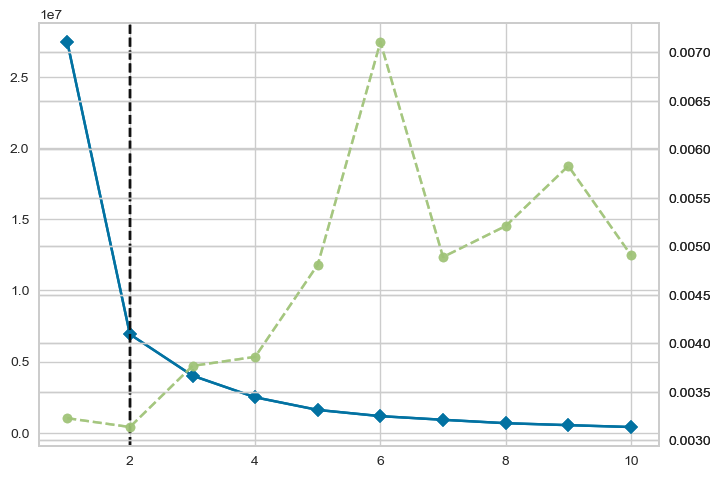

In [85]:
# 엘보우 차트 시각화
elbow_chart = KElbowVisualizer(km, k = (1,11)) # range 1 부터 11 까지
elbow_chart.fit(clean_df)
elbow_chart.draw()

C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

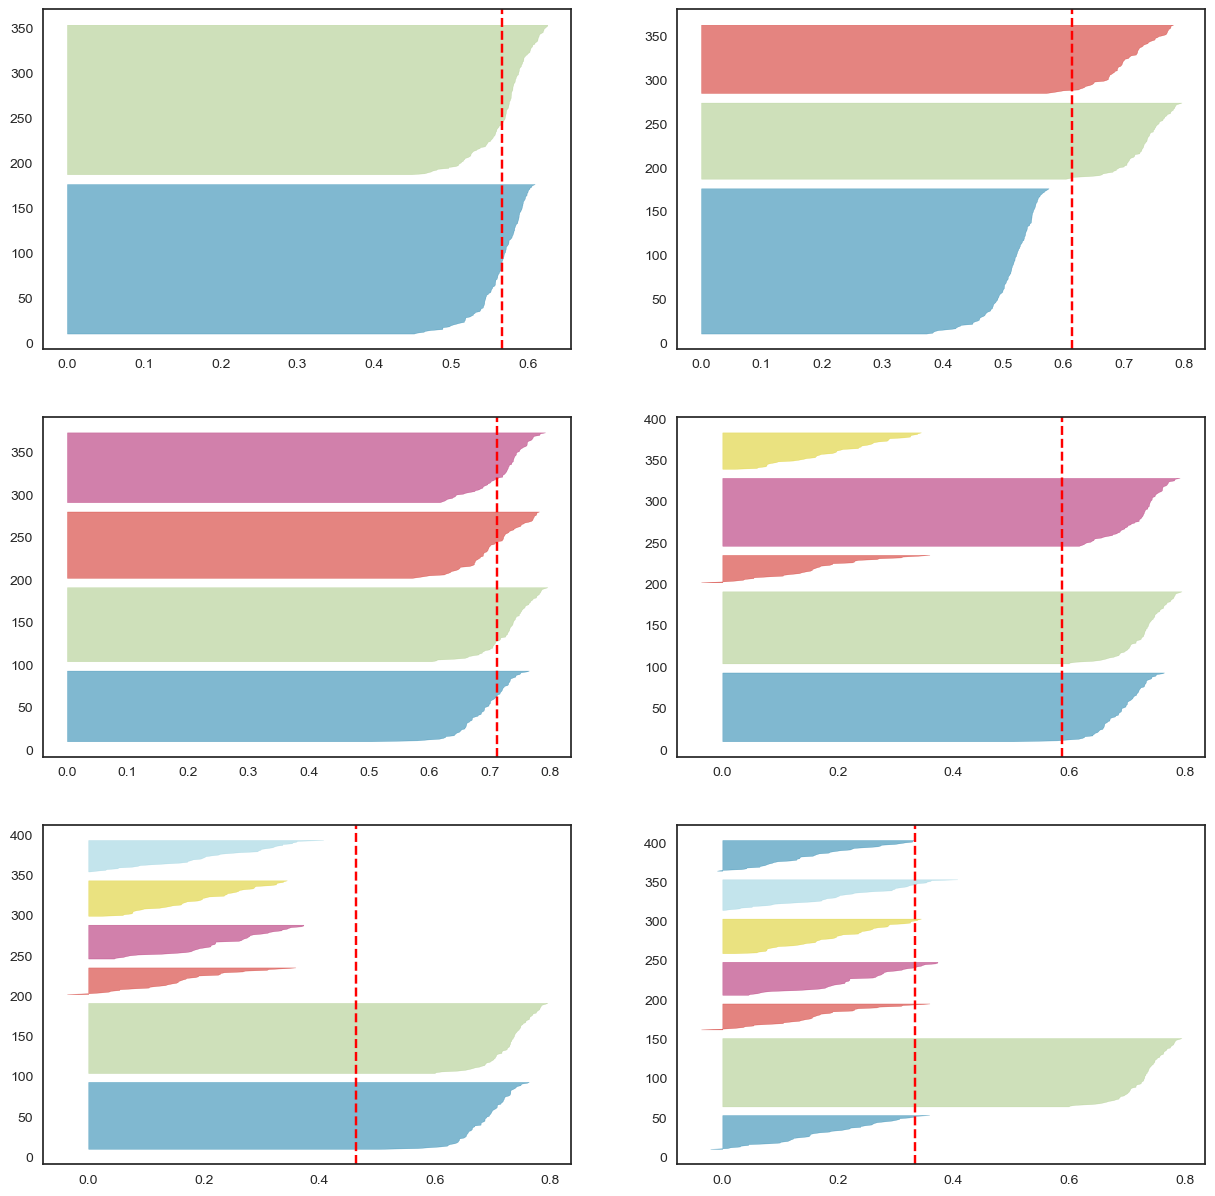

In [56]:
# 시각화
fig, ax = plt.subplots(3, 2, figsize = (15,15))

for i in range(2, 8):
    # k-means 모델
    kmeans_model = KMeans(n_clusters=i, random_state=33)

    q, mod = divmod(i, 2)

    # 실루엣 계수 시각화
    visualizer = SilhouetteVisualizer(kmeans_model, colors = "yellowbrick", ax = ax[q-1][mod])

    visualizer.fit(scaled_df)

- 2개의 군집 그리고 뭔가 4개도 보인다... 어?

# 수상하다 엘보우로 내리쳐보자

C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

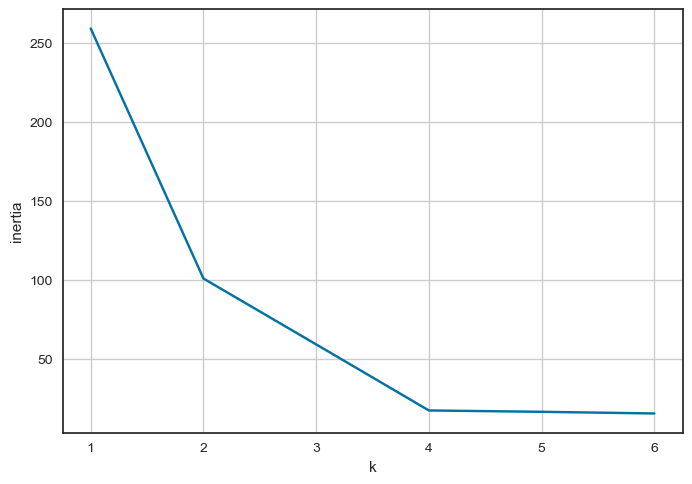

In [61]:
inertia = []

for k in range(1, 7):
    km = KMeans(n_clusters= k, random_state =33)
    km.fit(scaled_df)
    inertia.append(km.inertia_)

plt.plot(range(1,7), inertia)
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid()
plt.show()

C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


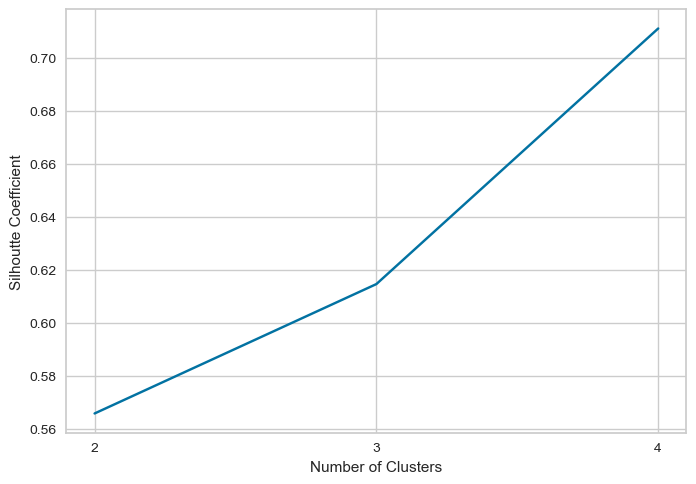

In [70]:
# 실루엣 계수 시각화 1
silhouette_coef = [] # 실루엣 계수 저장

# 실루엣 계수 그래프 생성
for k in range(2, 5):
    kmeans_silhouette = KMeans(n_clusters= k, random_state= 33)
    kmeans_silhouette.fit(scaled_df)

    score = silhouette_score(scaled_df, kmeans_silhouette.labels_)
    silhouette_coef.append(score)


sns.set_style("whitegrid")

plt.plot(range(2, 5), silhouette_coef)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Coefficient")
plt.show()

In [71]:
# k-means 클러스터 시각화 2개로 했을때와 4개로 했을때 보기
kmeans_model = KMeans(n_clusters=2, random_state=33)
# 군집 번호 결합
clean_df["cluster1"] = kmeans_model.fit_predict(scaled_df)

C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [75]:
# k-means 클러스터 시각화 2개로 했을때와 4개로 했을때 보기
kmeans_model2 = KMeans(n_clusters=4, random_state=33)
# 군집 번호 결합
clean_df["cluster2"] = kmeans_model2.fit_predict(scaled_df)

C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [77]:
clean_df.head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,Corrupted,cluster1,cluster2
0,8.0,391.09,1,2.96,7.0,72.37,9.96,0,3
1,20.0,720.99,0,3.04,9.0,69.08,12.04,0,0
2,31.0,356.32,1,3.71,8.0,70.58,11.71,0,3
3,2.0,228.08,1,2.48,8.0,70.80,10.48,0,3
4,20.0,408.50,0,3.57,8.0,71.28,11.57,0,0


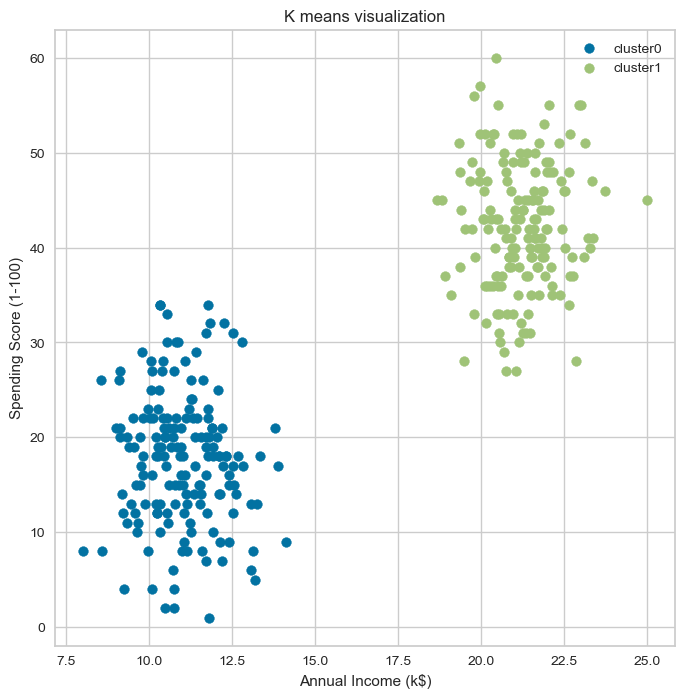

In [79]:
plt.figure(figsize = (8,8))

for i in range(clean_df["cluster1"].max() + 1):
    plt.scatter(clean_df.loc[clean_df["cluster1"] == i, "Corrupted"],
    clean_df.loc[clean_df["cluster1"] == i, "Session_Connection_Time"],
    label = "cluster" + str(i))

plt.legend()
plt.title("K means visualization", size = 12)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")

plt.show()

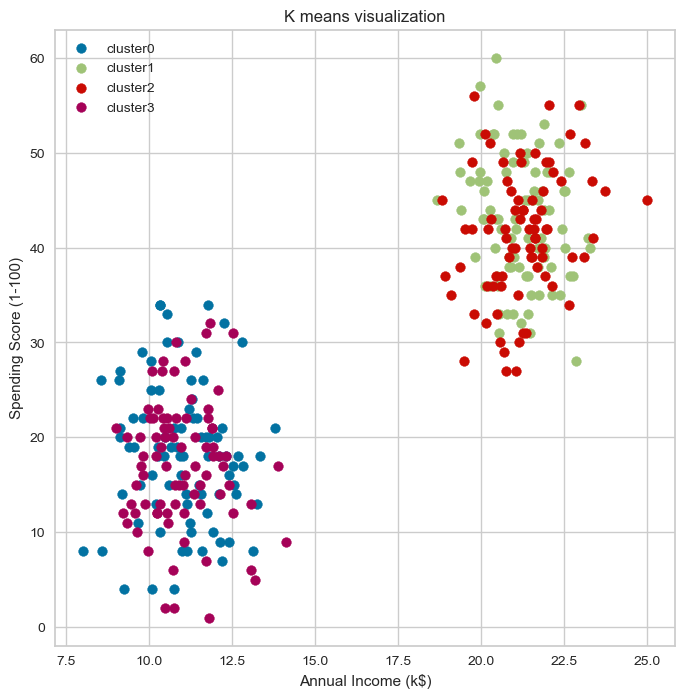

In [80]:
plt.figure(figsize = (8,8))

for i in range(clean_df["cluster2"].max() + 1):
    plt.scatter(clean_df.loc[clean_df["cluster2"] == i, "Corrupted"],
    clean_df.loc[clean_df["cluster2"] == i, "Session_Connection_Time"],
    label = "cluster" + str(i))

plt.legend()
plt.title("K means visualization", size = 12)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")

plt.show()

In [81]:
# 군집 4개 분석

In [82]:
clean_df = clean_df.groupby("cluster2").mean().reset_index()
clean_df["cluster2_cnt"] = clean_df.groupby("cluster2")["Corrupted"].count()

In [83]:
clean_df.head()

,cluster2,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,Corrupted,cluster1,cluster2_cnt
0,0,18.345238,360.296786,0.0,3.125833,7.880952,70.304881,11.006786,0.0,1
1,1,43.056818,846.851364,1.0,7.384432,13.784091,43.819091,21.168523,1.0,1
2,2,41.379747,826.056835,0.0,7.364684,13.873418,44.311139,21.238101,1.0,1
3,3,17.156627,394.862410,1.0,3.158193,7.819277,70.964940,10.977470,0.0,1


In [84]:
# 아.. 다시해야해..Kali_Trace_Used 이 특성으로 나눠졌어...

# Kali_Trace_Used 제외

In [106]:
clean_df = clean_df.drop("Kali_Trace_Used", axis = 1)

In [107]:
mm = MinMaxScaler()
scaled_df = mm.fit_transform(clean_df)

In [108]:
# k-means 클러스터 시각화 2개로 했을때와 4개로 했을때 보기
kmeans_model = KMeans(n_clusters=2, random_state=33)
# 군집 번호 결합
clean_df["cluster1"] = kmeans_model.fit_predict(scaled_df)


C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [109]:

# k-means 클러스터 시각화 2개로 했을때와 4개로 했을때 보기
kmeans_model2 = KMeans(n_clusters=4, random_state=33)
# 군집 번호 결합
clean_df["cluster2"] = kmeans_model2.fit_predict(scaled_df)


C:\Users\de051\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [110]:
clean_df

,Session_Connection_Time,Bytes Transferred,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,cluster1,cluster2
0,8.0,391.09,2.96,7.0,72.37,0,0
1,20.0,720.99,3.04,9.0,69.08,0,3
2,31.0,356.32,3.71,8.0,70.58,0,2
3,2.0,228.08,2.48,8.0,70.80,0,0
4,20.0,408.50,3.57,8.0,71.28,0,3
...,...,...,...,...,...,...,...
329,39.0,761.91,6.99,14.0,43.23,1,1
330,43.0,983.48,8.60,13.0,43.21,1,1
331,39.0,690.22,6.80,13.0,42.75,1,1
332,36.0,1060.69,6.26,14.0,43.86,1,1


In [111]:
# 오 완전 다름

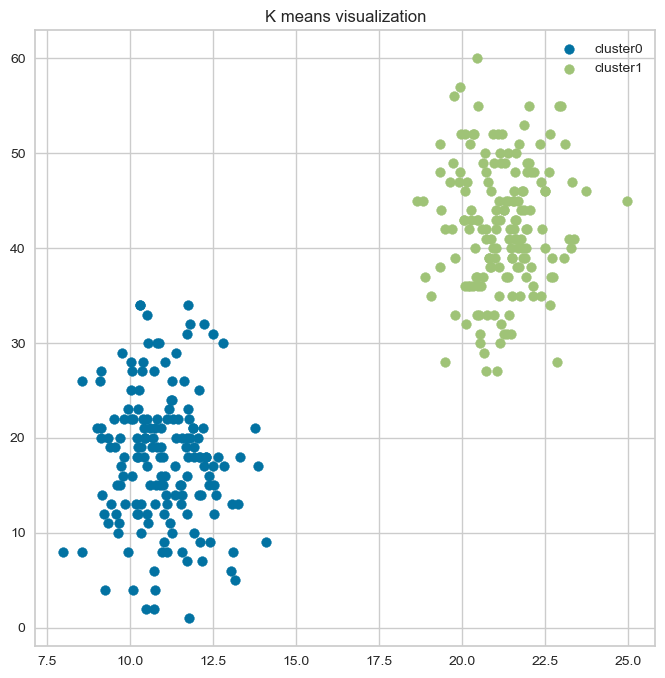

In [115]:
plt.figure(figsize = (8,8))

for i in range(clean_df["cluster1"].max() + 1):
    plt.scatter(clean_df.loc[clean_df["cluster1"] == i, "Corrupted"],
    clean_df.loc[clean_df["cluster1"] == i, "Session_Connection_Time"],
    label = "cluster" + str(i))

plt.legend()
plt.title("K means visualization", size = 12)
plt.show()

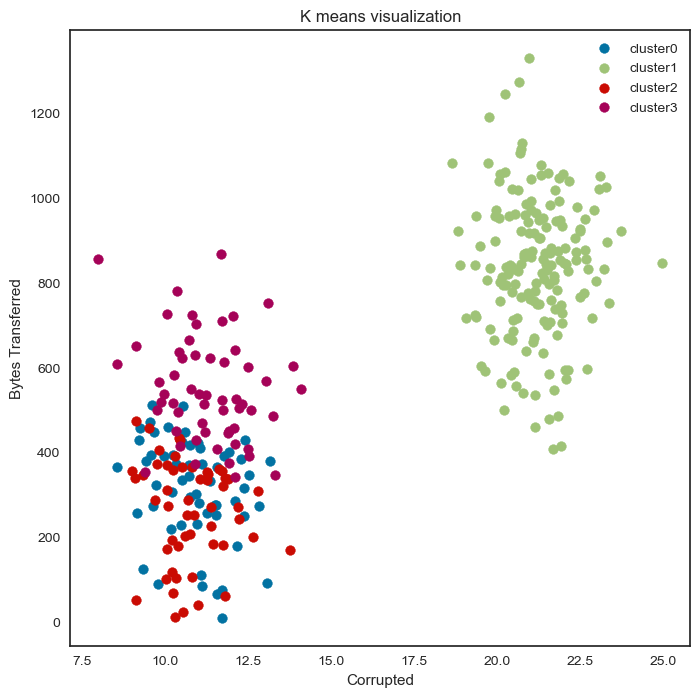

In [216]:
plt.figure(figsize = (8,8))

for i in range(clean_df["cluster2"].max() + 1):
    plt.scatter(clean_df.loc[clean_df["cluster2"] == i, "Corrupted"],
    clean_df.loc[clean_df["cluster2"] == i, "Bytes Transferred"],
    label = "cluster" + str(i))

plt.legend()
plt.title("K means visualization", size = 12)
plt.xlabel("Corrupted")
plt.ylabel("Bytes Transferred")

plt.show()

Corrupted 가 낮은곳에서 Session_Connection_time  부분이 3부분으로 나뉘네여?

Bytes Transferred 도 마찬가지임

In [211]:
weird_df = clean_df.groupby("cluster2").mean().reset_index()

weird_df.head()

In [199]:
# 세부류의 공격이 일정함
# 여기서 좀 차이가 나는것은 session 머무른 시간이 약간 다름
# 이걸로 3개가 나뉘는 듯

# 한 사람이 세번더 작업을 하는건지 
# 해킹시스템을 3명이 건드리는건지 잘 판단이 안됨요.

# Session_Connection_Time 과 Bytes Transferred의 차이가 유의미한지 보고 싶음

C:\Users\de051\AppData\Local\Temp\ipykernel_26284\3620720647.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster2', y='Session_Connection_Time', data = clean_df, palette = 'Set3')


<Axes: xlabel='cluster2', ylabel='Session_Connection_Time'>

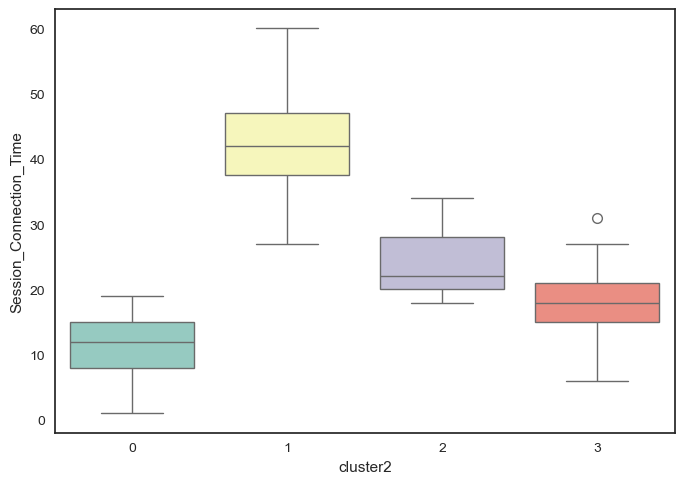

In [206]:
sns.boxplot(x='cluster2', y='Session_Connection_Time', data = clean_df, palette = 'Set3')

- 총 공격이 15이상 일때 1명이 했고
- 총 공격이 15 이하 일때 